# Import necessary libraries and modules

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import cv2
import imageio
import multiprocessing
from sklearn.model_selection import train_test_split

# Plan
* 
* Find corrupted images
* 

In [2]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [3]:
train_dir_img = '/kaggle/input/airbus-ship-detection/train_v2/'
test_dir_img = '/kaggle/input/airbus-ship-detection/test_v2/'
train_dir_csv = os.path.join('/kaggle/input/airbus-ship-detection/',
                                 'train_ship_segmentations_v2.csv')

In [4]:
masks = pd.read_csv(train_dir_csv)
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head(30)

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [5]:
image_file = masks['ImageId'].iloc[2]  # Get the name of the image from DataFrame
image_path = train_dir_img + image_file  

image = cv2.imread(image_path)

height = image.shape[0]
width = image.shape[1]
num_channels = image.shape[2]
print(height, width, num_channels)

768 768 3


In [6]:
def display_encoded_pixels_train(image_num, shape=(height, width)):
    image_file = masks['ImageId'].iloc[image_num]  # Get the name of the image from DataFrame
    image_path = train_dir_img + image_file  
    
    # Load and display the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV reads images in BGR format, so convert it to RGB
    
    mask_img = np.zeros((shape[0] * shape[1], 1), dtype=int)
    l,b=cv2.imread(image_path).shape[0], cv2.imread(image_path).shape[1]
    
    if pd.isna(masks['EncodedPixels'].iloc[image_num]):
        print("No ships")
    else:
        masks['EncodedPixels'].iloc[image_num].split(' ')
        rle = list(map(int, masks['EncodedPixels'].iloc[image_num].split(' ')))
        pixel,pixel_count = [],[]
        [pixel.append(rle[i]) if i % 2 ==0 else pixel_count.append(rle[i]) for i in range(0, len(rle))]
        rle_pixels = [list(range(pixel[i],pixel[i]+pixel_count[i])) for i in range(0, len(pixel))]
        rle_mask_pixels = sum(rle_pixels,[]) 
        mask_img[rle_mask_pixels] = 255
        
    mask = np.reshape(mask_img, (b, l)).T 
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    axes[1].imshow(mask)
    axes[1].set_title('Segmented Image')
    axes[1].axis('off')

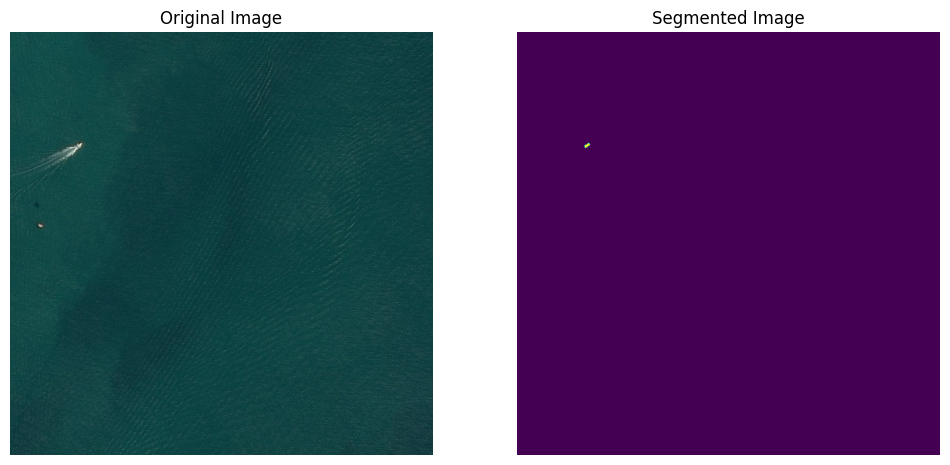

In [7]:
display_encoded_pixels_train(458, (height, width))

In [8]:
not_empty = pd.notna(masks.EncodedPixels)
print(not_empty.sum(), 'masks in', masks[not_empty].ImageId.nunique(), 'images')
print((~not_empty).sum(), 'empty images in', masks.ImageId.nunique(), 'total images')
masks.head()

81723 masks in 42556 images
150000 empty images in 192556 total images


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Notes
* Some images has different ships on it
* Size of image is (768, 768, 3)
* Numbers of unique images: 192556
* 150000 empty images
* 81723 masks in 42556 images

Conclution:
* Class imbalance problem (too much images without ships, maybe change train dataset to 70% images with ships, 30% images without ships)
* it's necessary to combine ship masks for each photo (if there is more than one ship in the photo)
* Add validation dataset or cross-validation

In [9]:
def is_image_corrupted(directory, filename):
        filepath = os.path.join(directory, filename)
        try:
            img = imageio.imread(filepath)
            pass
        except Exception as e:
            return filename
        return None
def find_corrupted_images_parallel(directory):
    # Get list of image filenames
    filenames = os.listdir(directory)

    # Create a pool of worker processes
    with multiprocessing.Pool() as pool:
        # Distribute the task of checking images across worker processes
        corrupted_images = pool.starmap(is_image_corrupted, [(directory, filename) for filename in filenames])

    # Filter out None values (indicating no corruption) and return list of corrupted images
    return [filename for filename in corrupted_images if filename is not None]

In [10]:
#corrupted_images_train = find_corrupted_images_parallel(train_dir_img)
# print("Corrupted images", corrupted_images_train)

In [11]:
# corrupted_images_test = find_corrupted_images_parallel(test_dir_img)
# print("Corrupted images", corrupted_images_test)

* So, Corrupted images ['6384c3e78.jpg'] in train set. Deleting it

* No corrupted images in test set


In [12]:
сorrupted_images = ['6384c3e78.jpg']

In [13]:
def combine_masks(encoded_pixels):
    masks = ' '.join(map(str, encoded_pixels))
    return masks


def process_image(image_id, group):
    encoded_pixels = group['EncodedPixels'].tolist()
    if np.all(pd.notna(encoded_pixels)):
        combined_mask = combine_masks(encoded_pixels)
        return image_id, combined_mask, len(group)
    else:
        return image_id, None, 0  

def parallel_process(data, func, num_processes=4):
    with multiprocessing.Pool(num_processes) as pool:
        return pool.starmap(func, data)


In [14]:
masks = masks[masks['ImageId'] != '6384c3e78.jpg']

In [15]:
grouped_data = masks.groupby('ImageId')

In [16]:
image_data = [(group_name, group) for group_name, group in grouped_data]
processed_results = parallel_process(image_data, process_image)

result_df = pd.DataFrame(processed_results, columns=['ImageId', 'CombinedMask', 'NumShips'])

In [17]:
result_df.head(10)

,ImageId,CombinedMask,NumShips
0,00003e153.jpg,None,0
1,0001124c7.jpg,None,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,None,0
5,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,9
6,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,2
7,0002d0f32.jpg,None,0
8,000303d4d.jpg,None,0
9,00031f145.jpg,340363 1 341129 4 341896 6 342663 7 343429 10 ...,1


In [18]:
number_img_train = len(result_df)
print(number_img_train)

192555


In [19]:
has_ships = result_df[result_df['NumShips'] != 0]
no_ships = result_df[result_df['NumShips'] == 0]

print(len(has_ships), len(no_ships))

42556 149999


In [20]:
number_img_train_noships = 40000

In [21]:
no_ships_less = no_ships[: number_img_train_noships]

In [22]:
X_train_pos, X_val_pos, y_train_pos, y_val_pos = train_test_split(has_ships['ImageId'], has_ships['CombinedMask'], test_size=0.15, random_state=47)
X_train_neg, X_val_neg, y_train_neg, y_val_neg = train_test_split(no_ships_less['ImageId'], no_ships_less['CombinedMask'], test_size=0.15, random_state=47)
